## Final Project - Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. 

Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: **how can we increase blight ticket compliance?**

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. 

#### For this project, my task was to predict whether or not a given blight ticket will be paid on time.

All data has been provided through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Here are related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

I was provided with two data files to use for in training and validating my models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. 

* The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. 
* Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

*Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.*

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to latitude and longitude coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

My predictions represent the probability that the corresponding blight ticket will be paid on time.

Area Under the ROC Curve (AUC) was used as the evaluation metric. 
___

For this project, I created a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, I determined the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [2]:
% matplotlib notebook

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

<IPython.core.display.Javascript object>


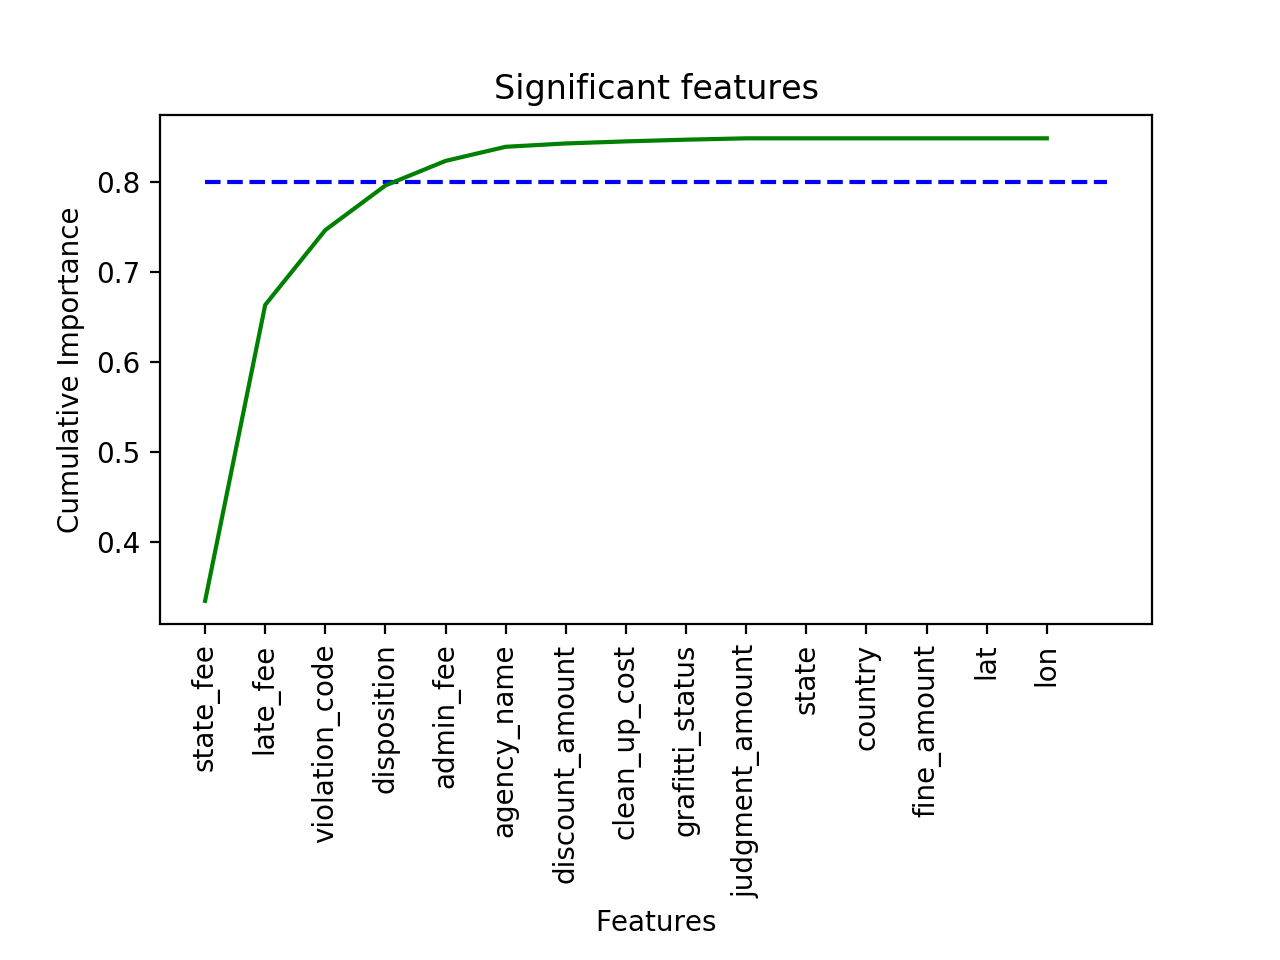

GridSearch best parameter (max. AUC):  {'max_depth': 5, 'n_estimators': 200}
GridSearch best score (AUC):  0.750969397684


ticket_id
284932    0.059562
285362    0.025201
285361    0.069722
285338    0.059562
285346    0.069722
285345    0.059562
285347    0.057520
285342    0.362001
285530    0.025201
284989    0.026905
dtype: float32

In [3]:
def blight_model():
    
    # To reduce memory, specify column datatypes upon reading in the file
    train = pd.read_csv('train.csv', encoding = 'ISO-8859-1', index_col='ticket_id', 
                                dtype = {'agency_name': object, 'inspector_name': object, 'violator_name': object, 
                                'violation_street_number': float, 'violation_street_name': object, 'violation_zip_code': float,
                                'mailing_address_str_number': float, 'mailing_address_str_name': object, 'city': object, 
                                'state': object, 'zip_code': object, 'non_us_str_code': object, 'country': object, 
                                'ticket_issued_date': object, 'hearing_date': object, 'violation_code': object, 
                                'violation_description': object, 'disposition': object, 'fine_amount': float,
                                'admin_fee': float, 'state_fee': float, 'late_fee': float, 'discount_amount': float, 
                                'clean_up_cost': float, 'judgment_amount': float, 'payment_amount': float, 
                                'balance_due': float, 'payment_date': object, 'payment_status': object, 
                                'collection_status': object, 'grafitti_status': object, 'compliance_detail': object, 
                                'compliance': float})

    test = pd.read_csv('test.csv', encoding = 'ISO-8859-1', index_col='ticket_id')
    addresses = pd.read_csv('addresses.csv', encoding = 'ISO-8859-1', index_col='ticket_id')
    coord = pd.read_csv('latlons.csv', encoding = 'ISO-8859-1')


    # Step 1: Collect data
    ## Use for obtaining latitude/longitude coordinates by:
    ## a) Mapping addresses -> latitude/longitude coordinates
    coord = coord.merge(addresses, how='left', on='address')
    ## Remove address column to avoid data leakage
    coord.drop(['address'], axis=1, inplace=True)

    ## b) Mapping ticket_id -> addresses
    train = train.merge(coord, how ='left', left_index=True, right_index=True)
    test = test.merge(coord, how ='left', left_index=True, right_index=True)
    
    train = train[~train['compliance'].isnull()]


    # Step 2: Variable selection
    ## Features: Select to decrease size of model
    features = ['agency_name', 'state', 'country', 'violation_code', 'disposition',
                'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
               'clean_up_cost', 'judgment_amount', 'grafitti_status', 'lat', 'lon']
    
    X_train = train[features] 
    X_test = test[features]
    
    ## Target: Whether or not violator complied and paid their fee.
    y_train = train['compliance']

    
    # Step 3) Clean data, using One-hot encoding.
    X_data = pd.concat(objs=[X_train, X_test], axis=0)
    ## Use sparse=True to reduce memory problems
    X_data = pd.get_dummies(X_data, sparse=True).reset_index(drop=True)

    num = X_train.shape[0]
    X_train = X_data[:num]
    X_test = X_data[num:]


    # Step 4) Impute missing data using the mean of each column
    X_train= X_train.apply(lambda x: x.fillna(x.mean()), axis=0)
    X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)
    

    # Step 5) Model selection. Evaluate Feature importance
    model = RandomForestClassifier().fit(X_train, y_train)

    ## A) Sort features, based on importance to target. Use results to refine final model
    feat_list = list(features)
    importance = list(model.feature_importances_)
    feat_importance = [(f, round(i, 4)) for f, i in zip(feat_list, importance)]
    feat_importance = sorted(feat_importance, key=lambda a: a[1], reverse=True)
    
    #print('Variable: {} Importance: {}'.format(*i)) for i in feat_importance]
    sorted_feat = [i[0] for i in feat_importance]
    sorted_importance = [i[1] for i in feat_importance]
    cum_importance = np.cumsum(sorted_importance)
    
    

    ## B) Make a line graph
    x_val = list(range(len(feat_list)))
    
    plt.gcf().subplots_adjust(bottom=0.35)
    plt.plot(x_val, cum_importance, 'g-',)
    # Draw line at 80% of importance retained
    plt.hlines(y = 0.80, xmin=0, xmax=len(sorted_importance), color = 'blue', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_val, sorted_feat, rotation = 'vertical')
    # Title and axis labels
    plt.title('Significant features'); plt.xlabel('Features'); plt.ylabel('Cumulative Importance'); 
    
    
    # Step 6) Feature Reduction
    ## Extract the names of the most important features
    ## Note: Only the top two features were selected, since the top third variable would add an extra 200 columns
    final_feat = [feat[0] for feat in feat_importance[0:2]]
    #print(final_feat)
    
    ## Only keep columns of the most important features. Create final X_train and X_test dataframes
    final_col = []
    
    final_col = [col for col in X_train.columns if col.startswith(tuple(final_feat))]
    ## Final, reduced dataframes
    final_train = X_train.loc[:, final_col]
    final_test = X_test.loc[:, final_col]
    
    
    # Step 7. Find optimal model
    # Revised model, using the final data
    model = RandomForestClassifier().fit(final_train, y_train)
    
    params = {
        'max_depth': [2, 5, 10, 20],
        'n_estimators': [100, 200, 300, 400]
    }
    
    grid = GridSearchCV(model, param_grid = params, scoring = 'roc_auc')
    grid.fit(final_train, y_train)
    best = grid.best_params_
    
    print('GridSearch best parameter (max. AUC): ', best)
    print('GridSearch best score (AUC): ', grid.best_score_)
    
    
    # Step 8) Final model
    final = RandomForestClassifier(max_depth=best['max_depth'], n_estimators=best['n_estimators']).fit(final_train, y_train)
    ## Make predictions using the test set
    y_hat = pd.Series(final.predict_proba(final_test)[:,1], index=test.index, dtype='float32')

    return y_hat

blight_model().head(10)